In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
from qiskit import IBMQ, QuantumCircuit
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import *
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import *
from qiskit_optimization.algorithms import MinimumEigenOptimizer 
from qiskit_optimization.algorithms.optimization_algorithm import OptimizationResult
from time import time
from getpass import getpass
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_optimization.algorithms import MinimumEigenOptimizer

/var/folders/m7/1jm4cxtj20b5f6lhz8lzbxzh0000gn/T/ipykernel_1940/1170161966.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/var/folders/m7/1jm4cxtj20b5f6lhz8lzbxzh0000gn/T/ipykernel_1940/1170161966.py:6: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.alg

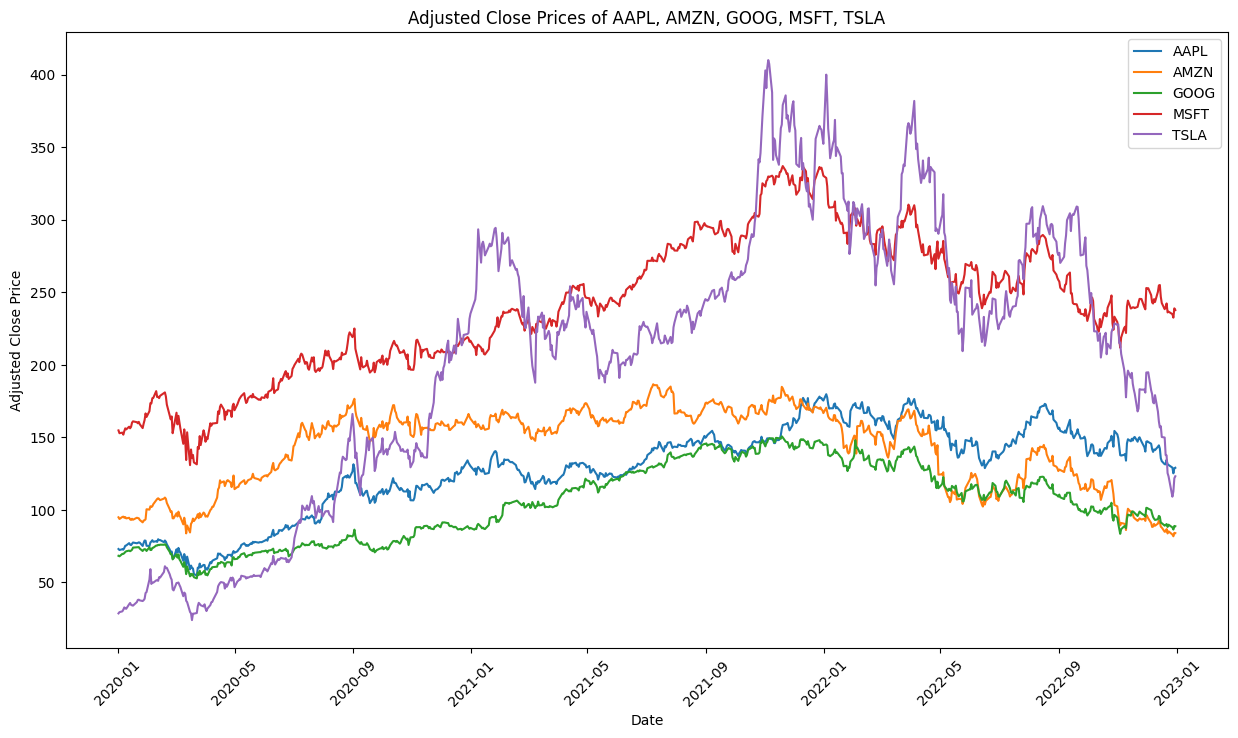

In [9]:
# Load the data from the file
file_path = 'data/stocks_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Remove non-data rows (such as headers and metadata in this dataset)
data_cleaned = data.drop([0, 1])  # Drop the first two rows

# Assuming the date information is in the first column after the dropped rows
data_cleaned['Date'] = pd.to_datetime(data_cleaned.iloc[:, 0])
data_cleaned.set_index('Date', inplace=True)

# Select only the columns for Adjusted Close Prices
adj_close_columns = [col for col in data_cleaned.columns if 'Adj Close' in col]
adj_close_data = data_cleaned[adj_close_columns]

# Rename columns for clarity
adj_close_data.columns = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'TSLA']

# Convert the data to numeric type for analysis
adj_close_data = adj_close_data.apply(pd.to_numeric)

# Plotting each stock's Adjusted Close Price
plt.figure(figsize=(15, 8))

for column in adj_close_data.columns:
    plt.plot(adj_close_data.index, adj_close_data[column], label=column)

plt.title('Adjusted Close Prices of AAPL, AMZN, GOOG, MSFT, TSLA')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()
plt.show()

In [10]:
# Calculate daily returns
daily_returns = adj_close_data.pct_change().dropna()

# Calculate mean return
mean_returns = daily_returns.mean()

# Calculate covariance matrix of returns
covariance_matrix = daily_returns.cov()

mean_returns, covariance_matrix

(AAPL    0.001024
 AMZN    0.000141
 GOOG    0.000580
 MSFT    0.000808
 TSLA    0.002965
 dtype: float64,
           AAPL      AMZN      GOOG      MSFT      TSLA
 AAPL  0.000541  0.000380  0.000367  0.000413  0.000550
 AMZN  0.000380  0.000606  0.000364  0.000378  0.000534
 GOOG  0.000367  0.000364  0.000469  0.000391  0.000446
 MSFT  0.000413  0.000378  0.000391  0.000479  0.000499
 TSLA  0.000550  0.000534  0.000446  0.000499  0.002068)

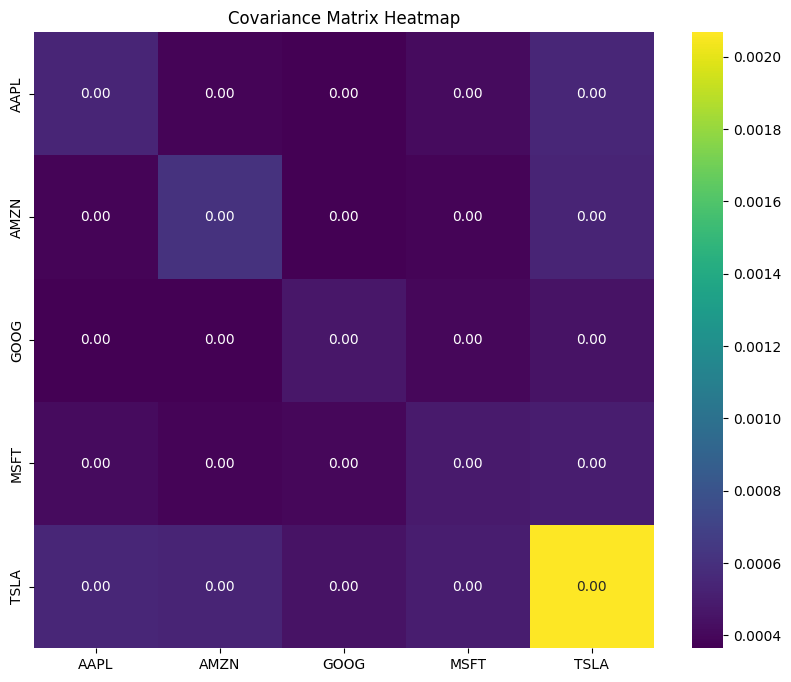

In [15]:
import seaborn as sns
# Plotting the covariance matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(covariance_matrix, annot=True, fmt='.2f', cmap='viridis')
plt.title('Covariance Matrix Heatmap')
plt.show()

In [23]:
# import pandas as pd

# dataset_folder = "data"
# symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA"]

# data = pd.DataFrame()

# # for symbol in symbols:
# #     filepath = f"{dataset_folder}/{symbol}.csv"
# #     try:
# #         df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
# #         # Assuming 'Close' column is present for calculating returns
# #         df[f'{symbol}_Return'] = df['Close'].pct_change()
# #         data = pd.concat([data, df[[f'{symbol}_Return']]], axis=1)
        
# #         # Print the first few rows of each DataFrame
# #         print(f"First few rows of data for {symbol}:")
# #         print(df.head())
# #         print("\n")  # Adding a newline for better readability

# #     except FileNotFoundError:
# #         print(f"File for {symbol} not found. Skipping this symbol.")
# #     except pd.errors.EmptyDataError:
# #         print(f"File for {symbol} is empty. Skipping this symbol.")
# #     except Exception as e:
# #         print(f"An error occurred while processing {symbol}: {e}")


# # specify the start date and end date of stock
# start_date = '2020-01-01'
# end_date = '2023-01-01'

# for symbol in symbols:
#     filepath = f"{dataset_folder}/{symbol}.csv"
#     try:
#         df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
        
#         # Filter the data for the date range
#         df = df.loc[start_date:end_date]
        
#         # Calculate returns
#         df[f'{symbol}_Return'] = df['Close'].pct_change()
        
#         # Concatenate the returns column to the data DataFrame
#         data = pd.concat([data, df[[f'{symbol}_Return']]], axis=1)

#         # Print the first few rows of each DataFrame
#         print(f"First few rows of data for {symbol}:")
#         print(df.head())
#         print("\n")  # Adding a newline for better readability

#     except FileNotFoundError:
#         print(f"File for {symbol} not found. Skipping this symbol.")
#     except pd.errors.EmptyDataError:
#         print(f"File for {symbol} is empty. Skipping this symbol.")
#     except Exception as e:
#         print(f"An error occurred while processing {symbol}: {e}")




File for AAPL not found. Skipping this symbol.
File for GOOG not found. Skipping this symbol.
File for MSFT not found. Skipping this symbol.
File for AMZN not found. Skipping this symbol.
File for TSLA not found. Skipping this symbol.


In [12]:
import pandas as pd

# # Load the data
# file_path = "data/stocks_data.csv"  # Adjust the file path if necessary
# # Read the CSV file
# df = pd.read_csv(file_path, index_col='Date')

# # Assuming 'Adj Close' prices are what you'll use to calculate returns
# # Filter the 'Adj Close' columns
# adj_close_prices = df.filter(like='Adj Close')

# # Calculate daily returns
# daily_returns = adj_close_prices.pct_change()

# # Drop the first row with NaN values that result from the pct_change calculation
# daily_returns = daily_returns.dropna()

# # Calculate the mean return vector (mean daily return for each stock)
# mean_return_vector = daily_returns.mean()

# # Calculate the covariance matrix of the returns
# covariance_matrix = daily_returns.cov()

# # Display the mean return vector and covariance matrix
# print("Mean Return Vector:")
# print(mean_return_vector)
# print("\nCovariance Matrix:")
# print(covariance_matrix)


In [33]:
# Calculate mean returns (mu) and covariance matrix
# mean_returns = data.mean() * 252  # Annualize the mean returns
# covariance_matrix = data.cov() * 252  # Annualize the covariance matrix

# # Print results
# print("Annualized Mean Returns (mu):")
# print(mean_returns)

# print("\nAnnualized Covariance Matrix:")
# print(covariance_matrix)

Annualized Mean Returns (mu):
Series([], dtype: float64)

Annualized Covariance Matrix:
Empty DataFrame
Columns: []
Index: []


In [13]:
# plt.figure(figsize=(12, 8))
# symbols = ["AAPL", "GOOG", "MSFT", "AMZN", "TSLA"]
# for symbol in symbols:
#     filepath = f"{dataset_folder}/{symbol}.csv"
#     try:
#         df = pd.read_csv(filepath, index_col="Date", parse_dates=True)
        
#         # Plotting the 'Close' prices on the same graph
#         plt.plot(df['Close'], label=f'{symbol} Close Price')

#     except FileNotFoundError:
#         print(f"File for {symbol} not found. Skipping this symbol.")
#     except pd.errors.EmptyDataError:
#         print(f"File for {symbol} is empty. Skipping this symbol.")
#     except Exception as e:
#         print(f"An error occurred while processing {symbol}: {e}")

# # Setting the title, labels and legend
# plt.title('Stock Close Price Comparison Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid(True)

# # Show the plot
# plt.show()

In [14]:
 # Path to the CSV file
# Path to the CSV file
# file_path = 'data/stocks_data.csv'

# try:
#     # Read the CSV file without specifying the index column
#     df = pd.read_csv(file_path)

#     # Displaying the first few rows of the dataset
#     print("First few rows of the dataset:")
#     print(df.head())

#     # Print the column names
#     print("\nColumn names in the dataset:")
#     print(df.columns)

# except FileNotFoundError:
#     print("The specified file was not found.")
# except pd.errors.EmptyDataError:
#     print("The file is empty.")
# except Exception as e:
#     print(f"An error occurred while reading the file: {e}")

In [22]:
# import seaborn as sns
# # Plot the covariance matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(covariance_matrix, annot=True, fmt=".2f", cmap='viridis', cbar=True)

# # Setting titles and labels
# plt.title('Covariance Matrix of Portfolio')
# plt.xticks(ticks=np.arange(0.5, len(covariance_matrix.columns), 1), labels=covariance_matrix.columns, rotation=90)
# plt.yticks(ticks=np.arange(0.5, len(covariance_matrix.index), 1), labels=covariance_matrix.index, rotation=0)
# plt.tight_layout()

# # Show the plot
# plt.show()

In [23]:
print("Length of mean_returns:", len(mean_returns))
print("Shape of covariance_matrix:", covariance_matrix.shape)

Length of mean_returns: 5
Shape of covariance_matrix: (5, 5)


In [24]:
num_assets = 5
q = 0.5  # set risk factor
budget = num_assets // 2  # set budget
penalty = num_assets  # set parameter to scale the budget penalty term

# Convert to numpy array if mean_returns is a pandas Series and covariance_matrix is a pandas DataFrame
expected_returns = mean_returns.values
covariances = covariance_matrix.values

portfolio = PortfolioOptimization(
    expected_returns=expected_returns,
    covariances=covariances,
    risk_factor=q,
    budget=budget
)
qp = portfolio.to_quadratic_program()
qp

<QuadraticProgram: minimize 0.0002706491719294765*x_0^2 + 0.000379892874514481..., 5 variables, 1 constraints, 'Portfolio optimization'>

In [25]:
def print_result(result):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

## Solving the problem classically using NumPyMinimumEigensolver for reference 


In [26]:
exact_mes = NumPyMinimumEigensolver()
exact_eigensolver = MinimumEigenOptimizer(exact_mes)

result = exact_eigensolver.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.0021

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 0 0 0 1]	-0.0021		1.0000


## Solution using `SamplingVQE`
We can now use the Sampling Variational Quantum Eigensolver (`SamplingVQE`) to solve the problem. We will specify the optimizer and variational form to be used.

In [19]:
from qiskit_algorithms.utils import algorithm_globals

algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=500)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
svqe_mes = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=cobyla)
svqe = MinimumEigenOptimizer(svqe_mes)
result = svqe.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.0021

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 0 0 0]	-0.0002		0.2109
[0 0 1 1 0]	-0.0005		0.2100
[1 0 0 1 0]	-0.0009		0.1104
[0 0 1 1 1]	-0.0015		0.0605
[0 1 0 0 0]	0.0002		0.0537
[0 0 1 0 0]	-0.0003		0.0479
[0 1 1 0 0]	0.0002		0.0430
[0 0 1 0 1]	-0.0018		0.0381
[1 0 0 0 1]	-0.0021		0.0352
[0 1 0 1 0]	-0.0000		0.0293
[1 0 1 0 0]	-0.0007		0.0264
[1 0 0 1 1]	-0.0018		0.0254
[1 0 1 1 0]	-0.0005		0.0176
[1 1 1 0 0]	0.0002		0.0166
[0 0 0 1 1]	-0.0020		0.0156
[1 0 0 0 0]	-0.0008		0.0156
[1 1 0 1 0]	0.0000		0.0146
[0 1 0 0 1]	-0.0012		0.0137
[1 0 1 0 1]	-0.0017		0.0039
[1 1 1 0 1]	-0.0002		0.0039
[0 1 1 1 0]	0.0004		0.0029
[0 0 0 1 0]	-0.0006		0.0029
[1 0 1 1 1]	-0.0009		0.0020


/Users/nich/Desktop/Qillers/virenv/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


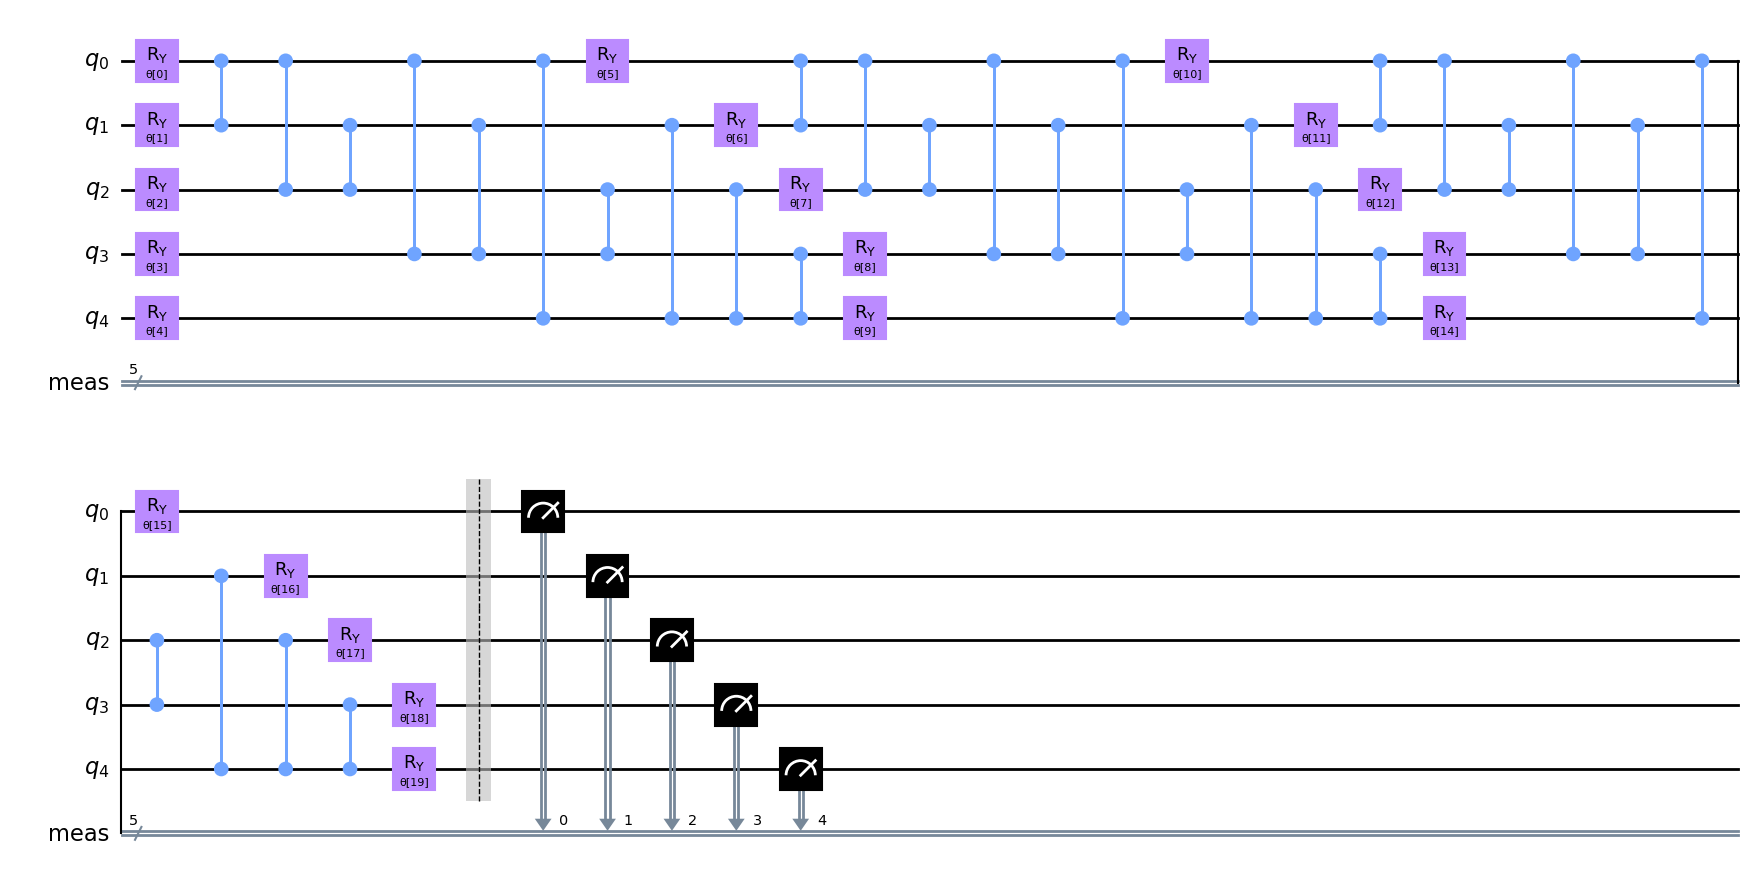

In [20]:
ry.decompose().draw("mpl") #Displaying the Ansatz circuit

### Solution using `QAOA`

We also show here a result using the Quantum Approximate Optimization Algorithm (`QAOA`). This is another variational algorithm and it uses an internal variational form that is created based on the problem.

In [21]:
algorithm_globals.random_seed = 1234

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa_mes = QAOA(sampler=Sampler(), optimizer=cobyla, reps=3)
qaoa = MinimumEigenOptimizer(qaoa_mes)
result = qaoa.solve(qp)

print_result(result)

Optimal: selection [1. 0. 0. 0. 1.], value -0.0021

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 1 1]	-0.0020		0.1035
[0 0 1 0 1]	-0.0018		0.0869
[0 1 0 0 1]	-0.0012		0.0869
[0 1 0 1 0]	-0.0000		0.0869
[0 0 1 1 0]	-0.0005		0.0869
[1 0 0 1 0]	-0.0009		0.0840
[1 0 0 0 1]	-0.0021		0.0840
[1 1 0 0 0]	-0.0002		0.0781
[1 0 1 0 0]	-0.0007		0.0762
[0 1 1 0 0]	0.0002		0.0674
[1 1 0 0 1]	-0.0011		0.0146
[1 0 1 1 0]	-0.0005		0.0137
[1 0 1 0 1]	-0.0017		0.0127
[0 0 0 1 0]	-0.0006		0.0117
[1 1 1 0 0]	0.0002		0.0107
[0 1 1 1 0]	0.0004		0.0098
[0 0 0 0 1]	-0.0019		0.0098
[0 0 0 0 0]	0.0000		0.0088
[0 1 0 0 0]	0.0002		0.0088
[0 1 0 1 1]	-0.0009		0.0088
[0 0 1 1 1]	-0.0015		0.0088
[0 0 1 0 0]	-0.0003		0.0088
[1 0 0 0 0]	-0.0008		0.0078
[1 1 0 1 0]	0.0000		0.0068
[1 0 0 1 1]	-0.0018		0.0068
[0 1 1 0 1]	-0.0008		0.0059
[1 1 1 1 1]	0.0009		0.0010
[1 1 1 1 0]	0.0008		0.0010
[0 1 1 1 1]	-0.0001		0.0010
[1 1 1 0 1]